<a href="https://colab.research.google.com/github/hafizbudi/active-learning/blob/main/Digits_RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Digits with random sampling**

## **Connect to google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd gdrive/My Drive/Project/active_learning

In [ ]:
pip install modal

## **Load library and digits data**

In [77]:
from dataclasses import dataclass
import dataclasses
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
import statistics
from tqdm import tqdm

from sklearn.datasets import load_digits
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling


## **Load, Train and Split data**

In [78]:
digits = load_digits()

# array to save number of instance and accuracy result
instance_number = []
accuracy_result = []

# flatten into 1d array
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
Y = digits.target

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)


In [79]:
# data_points 100,...,900
data_points=range(100,1000,100)

# train a classifier and predict
def train_and_predict(n_instances, X_train, y_train, X_test):
    clf = RandomForestClassifier()
    
    dataset_size = len(X_train)
    potential_candidates = list(range(dataset_size))
    train_indexes = np.array(random.sample(potential_candidates, n_instances))
    #print(train_indexes)
    clf.fit(X_train[train_indexes], y_train[train_indexes])
    predicted = clf.predict(X_test)
    return predicted

def random_selection_learning(n_instances, X_train, y_train):
    clf = RandomForestClassifier()
    #clf = LogisticRegression()
    X_selected, X_not_selected, y_selected, y_not_selected = \
        train_test_split(X_train, y_train, train_size=n_instances, shuffle=True)
    clf.fit(X_selected, y_selected)
    return clf, X_selected, X_not_selected, y_selected, y_not_selected

In [80]:
def evaluate(model, X_real, y_real):
    y_predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_real,y_predictions)
    #print(f"{accuracy}")
    return accuracy

@dataclass
class Experiment:
    n_samples: int
    repeat: int
    accuracy: float

def random_sampling_policy(model, n_new_samples, X_remaining, y_remaining):
    #print("n_new_samples ",n_new_samples)
    X_new_selected, X_remaining, y_new_selected, y_remaining = \
               train_test_split(X_remaining, y_remaining,  train_size=n_new_samples, shuffle=True)
    return X_new_selected, X_remaining, y_new_selected, y_remaining

def uncertainty_sampling_policy(model, n_new_samples, X_remaining, y_remaining):
    y_proba = model.predict_proba(X_remaining)
    uncertainty = 1.-np.max(y_proba, axis=1)
    #print(uncertainty)
    selected = -uncertainty.argsort()[:n_new_samples]
    non_selected = -uncertainty.argsort()[n_new_samples:]
    return X_remaining[selected], X_remaining[non_selected], y_remaining[selected], y_remaining[non_selected]

def learning_curve(data_points, repeats, selection_policy):
    experiments = []
    for i in tqdm(range(repeats)):
        # First learn 
        n_samples = data_points[0]
        #print("n_samples",n_samples)
        model, X_selected, X_remaining, y_selected, y_remaining = \
            random_selection_learning(n_samples, X_train, y_train)
        acc = evaluate(model, X_test, y_test)
        experiments.append(Experiment(n_samples=n_samples, repeat=i, accuracy=acc))
        for n_samples in data_points[1:]:
            # Select the additional examples
            n_new_samples = n_samples - len(X_selected)
            
            X_new_selected, X_remaining, y_new_selected, y_remaining = \
                selection_policy(model, n_new_samples, X_remaining, y_remaining)
            
            X_selected = np.vstack((X_selected, X_new_selected))
            y_selected = np.hstack((y_selected, y_new_selected))
            #print(X_selected.shape, y_selected.shape)
            model.fit(X_selected, y_selected)
            acc = evaluate(model, X_test, y_test)
            experiments.append(Experiment(n_samples=n_samples, repeat=i, accuracy=acc))
            
    #print("mean n 100", mean_n100)
    #print(mean_n)
    return experiments

experiments_random = learning_curve(data_points, 50, random_sampling_policy)
experiments_uncertainty = learning_curve(data_points, 50, uncertainty_sampling_policy)
print(experiments)
#print("Non-100 array",mn)

  0%|          | 0/50 [00:00<?, ?it/s]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative 

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 10%|█         | 5/50 [00:12<01:56,  2.60s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alte

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 20%|██        | 10/50 [00:23<01:25,  2.15s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 30%|███       | 15/50 [00:35<01:28,  2.52s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 40%|████      | 20/50 [00:46<01:09,  2.33s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 50%|█████     | 25/50 [00:58<00:59,  2.37s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 60%|██████    | 30/50 [01:10<00:47,  2.38s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 70%|███████   | 35/50 [01:23<00:37,  2.48s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 80%|████████  | 40/50 [01:34<00:22,  2.26s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 90%|█████████ | 45/50 [01:45<00:11,  2.23s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
  4%|▍         | 2/50 [00:02<01:05,  1.36s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alte

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 14%|█▍        | 7/50 [00:09<01:01,  1.42s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alte

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 24%|██▍       | 12/50 [00:17<00:56,  1.48s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 34%|███▍      | 17/50 [00:24<00:48,  1.46s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 44%|████▍     | 22/50 [00:31<00:40,  1.46s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 54%|█████▍    | 27/50 [00:39<00:34,  1.52s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 68%|██████▊   | 34/50 [00:49<00:24,  1.52s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 78%|███████▊  | 39/50 [00:56<00:15,  1.43s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

 88%|████████▊ | 44/50 [01:04<00:08,  1.46s/it]/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/cerquide/prj/active-learning/.venv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

[Experiment(n_samples=100, repeat=0, accuracy=0.8333333333333334), Experiment(n_samples=200, repeat=0, accuracy=0.9466666666666667), Experiment(n_samples=300, repeat=0, accuracy=0.9444444444444444), Experiment(n_samples=400, repeat=0, accuracy=0.9533333333333334), Experiment(n_samples=500, repeat=0, accuracy=0.9733333333333334), Experiment(n_samples=600, repeat=0, accuracy=0.9622222222222222), Experiment(n_samples=700, repeat=0, accuracy=0.9688888888888889), Experiment(n_samples=800, repeat=0, accuracy=0.9733333333333334), Experiment(n_samples=900, repeat=0, accuracy=0.9644444444444444), Experiment(n_samples=100, repeat=1, accuracy=0.7644444444444445), Experiment(n_samples=200, repeat=1, accuracy=0.9022222222222223), Experiment(n_samples=300, repeat=1, accuracy=0.92), Experiment(n_samples=400, repeat=1, accuracy=0.94), Experiment(n_samples=500, repeat=1, accuracy=0.9488888888888889), Experiment(n_samples=600, repeat=1, accuracy=0.9555555555555556), Experiment(n_samples=700, repeat=1, a

In [71]:
print(dataclasses.asdict(experiments[0]))

{'n_samples': 100, 'repeat': 0, 'accuracy': 0.8333333333333334}


In [72]:
df = pd.DataFrame([dataclasses.asdict(e) for e in experiments])
print(df)

    n_samples  repeat  accuracy
0         100       0  0.833333
1         200       0  0.946667
2         300       0  0.944444
3         400       0  0.953333
4         500       0  0.973333
5         600       0  0.962222
6         700       0  0.968889
7         800       0  0.973333
8         900       0  0.964444
9         100       1  0.764444
10        200       1  0.902222
11        300       1  0.920000
12        400       1  0.940000
13        500       1  0.948889
14        600       1  0.955556
15        700       1  0.944444
16        800       1  0.951111
17        900       1  0.964444
18        100       2  0.880000
19        200       2  0.908889
20        300       2  0.933333
21        400       2  0.926667
22        500       2  0.948889
23        600       2  0.960000
24        700       2  0.968889
25        800       2  0.971111
26        900       2  0.980000
27        100       3  0.800000
28        200       3  0.900000
29        300       3  0.942222
30      

In [75]:
def plot_learning_curve(df, name):
    # Compute percentiles
    p10 = df.groupby('n_samples').quantile(.10)['accuracy']
    p50 = df.groupby('n_samples').median()['accuracy']
    p90 = df.groupby('n_samples').quantile(.90)['accuracy']
    training_sizes= p50.index.to_numpy()

    with plt.style.context('seaborn-white'):
        plt.title('Learning curve for classifier '+name)
        plt.plot(training_sizes, p50, label=name, marker='o')

        # show standard deviation
        plt.fill_between(training_sizes, p10, p90,alpha=0.1,label='10-90 IQ')
    #plt.legend(loc='upper left')
    plt.xlabel("N sample")
    plt.ylabel("Accuracy")
    plt.grid()
    #plt.show()

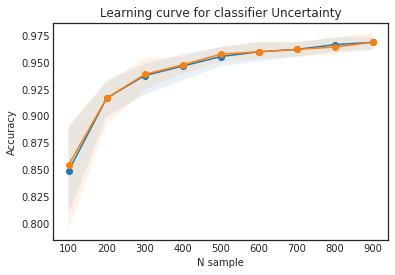

In [76]:
df_random = pd.DataFrame([dataclasses.asdict(e) for e in experiments_random])
df_us = pd.DataFrame([dataclasses.asdict(e) for e in experiments_uncertainty])
plot_learning_curve(df_random, "Random")
plot_learning_curve(df_us, "Uncertainty")